In [19]:
import pandas as pd
import numpy as np

pd.set_option('display.float_format', lambda x: '%.2f' % x)

df = pd.read_excel('Canada Cattle.xlsx')

# Set Year as index and convert to_period to yearly
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df = df.set_index('Year')
df = df.to_period('Y')

# df.describe()

# Copy the dataframe
df_full = df.copy()

# Split dataframes into Cattle and Calves
df_cattle = df.copy()
df_cattle.drop(['Count of Calves','Average Weight Cattle', 'Average Weight Calves'], axis=1, inplace=True)

df_calve = df.copy()
df_calve.drop(['Count of Cattle','Average Weight Cattle', 'Average Weight Calves'], axis=1, inplace=True)


In [20]:
# Normalize Function
def normalize(df):
    df_norm = (df - df.mean()) / (df.max() - df.min())
    return df_norm

# Unormalize Function
def unormalize(df, df_norm):
    df_unorm = df_norm * (df.max() - df.min()) + df.mean()
    return df_unorm

df_cattle_copy = df_cattle.copy()
df_calve_copy = df_calve.copy()

# Normalize both dataframes
df_cattle = normalize(df_cattle)
df_calve = normalize(df_calve)


ARIMA For Cattle

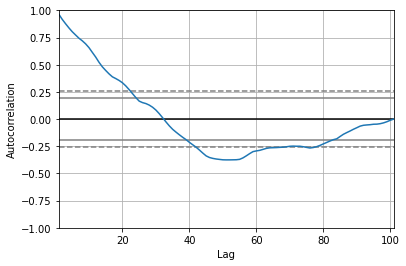

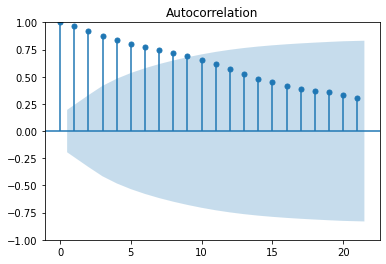

In [21]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import pyplot as plt

autocorrelation_plot(df_cattle)
plot_acf(df_cattle)
plt.show()

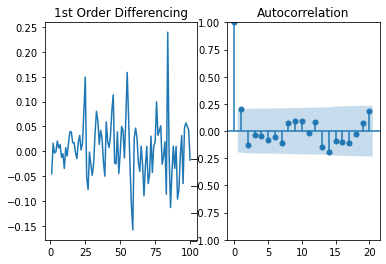

In [22]:
# Differencing df_cattle Plot and ACF
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('1st Order Differencing')
ax1.plot(df_cattle.diff().values)

ax2 = f.add_subplot(122)
plot_acf(df_cattle.diff().dropna().values, ax=ax2)
plt.show()

# 1st order differencing looks to be better than no differencing

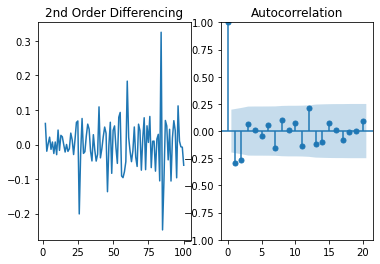

In [23]:
# Differencing df_cattle Plot and ACF
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('2nd Order Differencing')
ax1.plot(df_cattle.diff().diff().values)

ax2 = f.add_subplot(122)
plot_acf(df_cattle.diff().diff().dropna().values, ax=ax2)
plt.show()

# 1st order differencing looks to be better than no differencing

                               SARIMAX Results                                
Dep. Variable:        Count of Cattle   No. Observations:                  101
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 146.680
Date:                Sun, 24 Jul 2022   AIC                           -289.361
Time:                        16:35:06   BIC                           -284.150
Sample:                    12-31-1920   HQIC                          -287.252
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2112      0.080      2.656      0.008       0.055       0.367
sigma2         0.0031      0.000     11.461      0.000       0.003       0.004
Ljung-Box (L1) (Q):                   0.07   Jarque-

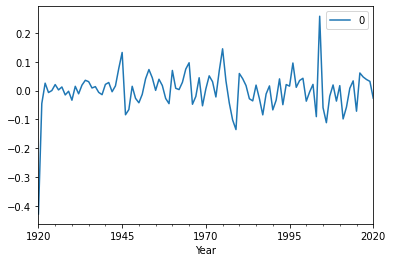

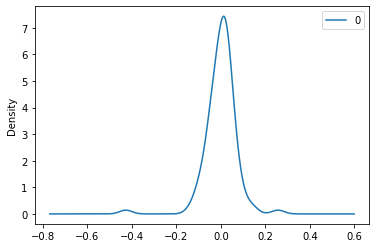

           0
count 101.00
mean    0.00
std     0.07
min    -0.43
25%    -0.03
50%     0.01
75%     0.03
max     0.26


In [24]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_cattle, order=(1, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

# density plot of residuals
residuals.plot(kind='kde')
plt.show()

# summary of residuals
print(residuals.describe())


predicted=0.297434, expected=0.251970
predicted=0.242386, expected=0.241922
predicted=0.238177, expected=0.261312
predicted=0.268519, expected=0.175231
predicted=0.143958, expected=0.414450
predicted=0.475905, expected=0.406152
predicted=0.404506, expected=0.293288
predicted=0.270635, expected=0.250107
predicted=0.241099, expected=0.260521
predicted=0.262674, expected=0.226400
predicted=0.219389, expected=0.236334
predicted=0.238356, expected=0.140404
predicted=0.121198, expected=0.063016
predicted=0.046105, expected=0.054690
predicted=0.052889, expected=0.086611
predicted=0.093489, expected=0.022008
predicted=0.008560, expected=0.069366
predicted=0.078636, expected=0.126434
predicted=0.138009, expected=0.176783
predicted=0.187343, expected=0.219372
predicted=0.228516, expected=0.201846


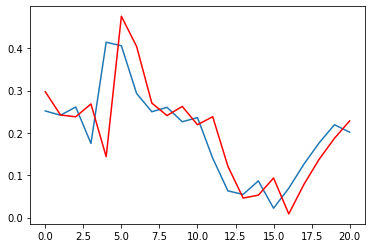

Test RMSE: 0.079
Test MAPE: 0.455
Test MAE: 0.056


In [25]:
# evaluate an ARIMA model using a walk-forward validation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

# Split dataset into train and test
x = df_cattle.values
size = int(len(df_cattle) * 0.8)
train, test = x[0:size], x[size:len(df_cattle)]
history = [x for x in train]
predictions = []

# Walk-forward validation for ARIMA model
for i in range(len(test)):
    model = ARIMA(history, order=(1, 1, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[i]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

# evaluate forecasts
error = mean_squared_error(test, predictions)

# plot forecasts against actual values
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# Calculate RMSE
rmse = sqrt(error)
print('Test RMSE: %.3f' % rmse)

# Calculate MAPE
mape = mean_absolute_percentage_error(test, predictions)
print('Test MAPE: %.3f' % mape)

# Calculate MAE
mae = mean_absolute_error(test, predictions)
print('Test MAE: %.3f' % mae)



In [26]:
# Forecast the next 10 years
# forecast = model_fit.forecast(steps = 10)
# print(forecast)

start_index =len(df_cattle)
end_index = start_index + 10
forecast = model_fit.predict(start=start_index, end=end_index)

print(forecast)


[0.23047972 0.23090128 0.2309918  0.23101123 0.2310154  0.2310163
 0.23101649 0.23101653 0.23101654 0.23101654 0.23101654]


ARIMA For Calves

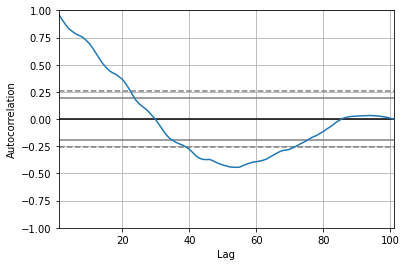

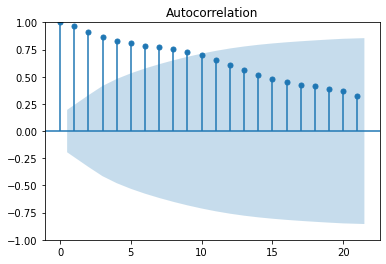

In [27]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import pyplot as plt

autocorrelation_plot(df_calve)
plot_acf(df_calve)
plt.show()

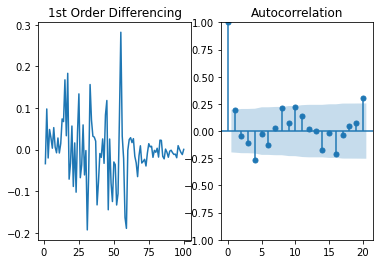

In [28]:
# Differencing df_cattle Plot and ACF
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('1st Order Differencing')
ax1.plot(df_calve.diff().values)

ax2 = f.add_subplot(122)
plot_acf(df_calve.diff().dropna().values, ax=ax2)
plt.show()

# 1st order differencing looks to be better than no differencing

                               SARIMAX Results                                
Dep. Variable:        Count of Calves   No. Observations:                  101
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 123.875
Date:                Sun, 24 Jul 2022   AIC                           -243.749
Time:                        16:35:08   BIC                           -238.539
Sample:                    12-31-1920   HQIC                          -241.640
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1932      0.092      2.111      0.035       0.014       0.373
sigma2         0.0049      0.000     10.020      0.000       0.004       0.006
Ljung-Box (L1) (Q):                   0.03   Jarque-

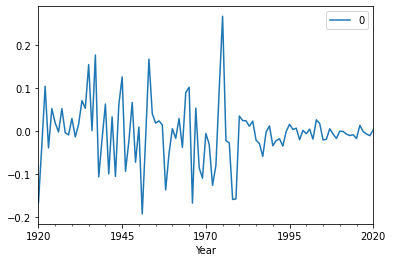

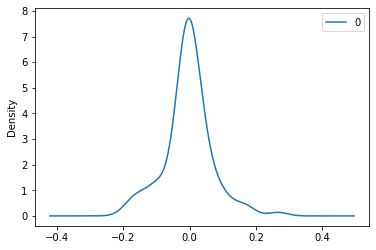

           0
count 101.00
mean   -0.00
std     0.07
min    -0.19
25%    -0.02
50%    -0.00
75%     0.02
max     0.27


In [29]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_calve, order=(1, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

# density plot of residuals
residuals.plot(kind='kde')
plt.show()

# summary of residuals
print(residuals.describe())


predicted=-0.330913, expected=-0.336994
predicted=-0.338236, expected=-0.333737
predicted=-0.333109, expected=-0.351767
predicted=-0.355246, expected=-0.329051
predicted=-0.324689, expected=-0.306891
predicted=-0.302617, expected=-0.323173
predicted=-0.326299, expected=-0.345413
predicted=-0.349697, expected=-0.344222
predicted=-0.343993, expected=-0.350655
predicted=-0.351893, expected=-0.369003
predicted=-0.372538, expected=-0.372736
predicted=-0.373456, expected=-0.374246
predicted=-0.374536, expected=-0.381712
predicted=-0.383151, expected=-0.393388
predicted=-0.395640, expected=-0.404269
predicted=-0.406371, expected=-0.423809
predicted=-0.427590, expected=-0.414357
predicted=-0.412532, expected=-0.413642
predicted=-0.413504, expected=-0.420393
predicted=-0.421697, expected=-0.432308
predicted=-0.434609, expected=-0.431831


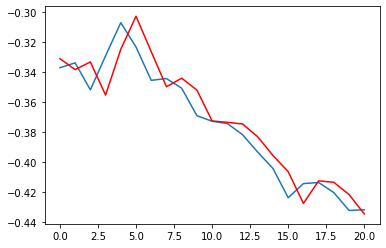

Test RMSE: 0.013
Test MAPE: 0.029
Test MAE: 0.011


In [30]:
# evaluate an ARIMA model using a walk-forward validation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

# Split dataset into train and test
x = df_calve.values
size = int(len(df_calve) * 0.8)
train, test = x[0:size], x[size:len(df_calve)]
history = [x for x in train]
predictions = []

# Walk-forward validation for ARIMA model
for i in range(len(test)):
    model = ARIMA(history, order=(1, 1, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[i]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

# evaluate forecasts
error = mean_squared_error(test, predictions)

# plot forecasts against actual values
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# Calculate RMSE
rmse = sqrt(error)
print('Test RMSE: %.3f' % rmse)

# Calculate MAPE
mape = mean_absolute_percentage_error(test, predictions)
print('Test MAPE: %.3f' % mape)

# Calculate MAE
mae = mean_absolute_error(test, predictions)
print('Test MAE: %.3f' % mae)



In [12]:
# Forecast the next 10 years

start_index =len(df_calve)
end_index = start_index + 10
forecast = model_fit.predict(start=start_index, end=end_index)

print(forecast)


[3420.11558942 3421.557434   3421.86339179 3421.92831569 3421.94209247
 3421.94501589 3421.94563623 3421.94576787 3421.9457958  3421.94580173
 3421.94580299]
